In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, LSTM, Dense,
    Concatenate, GaussianNoise
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
# --- CONFIG ---
SEQ_LEN = 300
STEP = 20
BATCH_SIZE = 32
EPOCHS = 50

def load_sequences_from_csv(path, label, seq_len=SEQ_LEN, step=STEP):
    df = pd.read_csv(path)
    df = df.dropna(subset=["SINR(dB)", "PathLoss_dB"])
    
    sinr = df["SINR(dB)"].values.astype(np.float32)
    rssi = df["PathLoss_dB"].values.astype(np.float32)
    
    # Normalize
    sinr = (sinr - np.mean(sinr)) / (np.std(sinr) + 1e-6)
    rssi = (rssi - np.mean(rssi)) / (np.std(rssi) + 1e-6)
    
    sinr_sequences, rssi_sequences, labels = [], [], []
    for i in range(0, len(sinr) - seq_len + 1, step):
        sinr_seq = sinr[i:i+seq_len][:, np.newaxis]
        rssi_seq = rssi[i:i+seq_len][:, np.newaxis]
        sinr_sequences.append(sinr_seq)
        rssi_sequences.append(rssi_seq)
        labels.append(label)
        
    return rssi_sequences, sinr_sequences, labels

In [8]:
import os

# Your class-wise CSV file paths
class_files = {
    0: [  # Normal
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_NOJam_Static.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_NOJam_ue_mv.csv"
    ],
    1: [  # Jam Only
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_Static.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_ue_mv.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_attack_mv.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_both_mv.csv"
    ],
    2: [  # Jam + IRS
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_IRSJam_Static.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_IRSJam_ue_mv.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_IRSJam_attack_mv.csv",
        r"C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_IRSJam_both_mv.csv"
    ]
}

missing_files = []

# Check each file
for label, file_list in class_files.items():
    print(f"\n🔍 Checking files for class {label}...")
    for file_path in file_list:
        if os.path.exists(file_path):
            print(f"✅ Found: {file_path}")
        else:
            print(f"❌ Missing: {file_path}")
            missing_files.append(file_path)

# Summary
print("\n📦 File Check Complete.")
if missing_files:
    print("❗ The following files were NOT found:")
    for f in missing_files:
        print(" -", f)
else:
    print("🎉 All files are present!")



🔍 Checking files for class 0...
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_NOJam_Static.csv
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_NOJam_ue_mv.csv

🔍 Checking files for class 1...
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_Static.csv
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_ue_mv.csv
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_attack_mv.csv
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_Jam_both_mv.csv

🔍 Checking files for class 2...
✅ Found: C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_IRSJam_Static.csv
✅ Found: C:\Users\VEDANT

In [9]:
X_rssi_all, X_sinr_all, y_all = [], [], []

for label, files in class_files.items():
    print(label)
    print(files)

    
    for file_path in files:
        rssi_seq, sinr_seq, labels = load_sequences_from_csv(file_path, label)
        X_rssi_all.extend(rssi_seq)
        X_sinr_all.extend(sinr_seq)
        y_all.extend(labels)
        print(f"✅ Loaded {len(labels)} samples from {file_path} | Label: {label}")

print("\n📊 Total Samples:", len(y_all))
print("Class Distribution:", Counter(y_all))

0
['C:\\Users\\VEDANT DESHMUKH\\OneDrive\\Desktop\\SEM 8\\CV_Latest\\3mins_IITG_lessAccuracy\\dataset\\RSSI_SINR_NOJam_Static.csv', 'C:\\Users\\VEDANT DESHMUKH\\OneDrive\\Desktop\\SEM 8\\CV_Latest\\3mins_IITG_lessAccuracy\\dataset\\RSSI_SINR_NOJam_ue_mv.csv']
✅ Loaded 4521 samples from C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_NOJam_Static.csv | Label: 0
✅ Loaded 5413 samples from C:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\dataset\RSSI_SINR_NOJam_ue_mv.csv | Label: 0
1
['C:\\Users\\VEDANT DESHMUKH\\OneDrive\\Desktop\\SEM 8\\CV_Latest\\3mins_IITG_lessAccuracy\\dataset\\RSSI_SINR_Jam_Static.csv', 'C:\\Users\\VEDANT DESHMUKH\\OneDrive\\Desktop\\SEM 8\\CV_Latest\\3mins_IITG_lessAccuracy\\dataset\\RSSI_SINR_Jam_ue_mv.csv', 'C:\\Users\\VEDANT DESHMUKH\\OneDrive\\Desktop\\SEM 8\\CV_Latest\\3mins_IITG_lessAccuracy\\dataset\\RSSI_SINR_Jam_attack_mv.csv', 'C:\\Users\\VEDANT DESHMUKH\\OneDrive\\Deskto

In [10]:
import numpy as np
from collections import Counter

def augment_with_noise(data, noise_level=0.05, copies=2):
    """Add Gaussian noise to time-series data."""
    augmented = []
    for _ in range(copies):
        noise = np.random.normal(loc=0.0, scale=noise_level, size=data.shape)
        augmented.append(data + noise)
    return np.concatenate(augmented, axis=0)

# Suppose you have loaded these already
# X_rssi_all, X_sinr_all, y_all = lists of data
# Convert to arrays
X_rssi_all = np.array(X_rssi_all)
X_sinr_all = np.array(X_sinr_all)
y_all = np.array(y_all)

# Filter only class 0 samples (Normal)
class0_idx = np.where(y_all == 0)[0]
X_rssi_class0 = X_rssi_all[class0_idx]
X_sinr_class0 = X_sinr_all[class0_idx]

# Augment class 0: 2x copies (feel free to tune)
X_rssi_aug = augment_with_noise(X_rssi_class0, noise_level=0.05, copies=1)
X_sinr_aug = augment_with_noise(X_sinr_class0, noise_level=0.05, copies=1)
y_aug = np.zeros(X_rssi_aug.shape[0], dtype=int)  # class 0 labels

# Concatenate back into full dataset
X_rssi_all = np.concatenate([X_rssi_all, X_rssi_aug], axis=0)
X_sinr_all = np.concatenate([X_sinr_all, X_sinr_aug], axis=0)
y_all = np.concatenate([y_all, y_aug], axis=0)

print("✅ After Augmentation:")
print("Class Distribution:", Counter(y_all))


✅ After Augmentation:
Class Distribution: Counter({1: 20085, 0: 19868, 2: 19550})


In [11]:
X_rssi = np.array(X_rssi_all)
X_sinr = np.array(X_sinr_all)
y_cat = to_categorical(y_all, num_classes=3)

# --- Split Dataset ---
X_rssi_train, X_rssi_val, X_sinr_train, X_sinr_val, y_train, y_val = train_test_split(
    X_rssi, X_sinr, y_cat, test_size=0.3, stratify=y_all, random_state=42
)

# --- Class Weights ---
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_all), y=y_all)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("🧮 Class Weights:", class_weights_dict)



🧮 Class Weights: {0: 0.9983054828534997, 1: 0.9875197079080574, 2: 1.014543904518329}


In [9]:


from keras.layers import LayerNormalization

def conv_block(x):
    x = Conv1D(16, 5, strides=2, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = LayerNormalization()(x)
    x = Conv1D(32, 3, strides=1, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = LayerNormalization()(x)
    return x

def build_final_model(seq_len):
    # RSSI branch
    rssi_input = Input(shape=(seq_len, 1), name="RSSI_Input")
    x_rssi = GaussianNoise(0.1)(rssi_input)
    x_rssi = conv_block(x_rssi)
    x_rssi = LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1)(x_rssi)

    # SINR branch
    sinr_input = Input(shape=(seq_len, 1), name="SINR_Input")
    x_sinr = GaussianNoise(0.1)(sinr_input)
    x_sinr = conv_block(x_sinr)
    x_sinr = LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.1)(x_sinr)

    # Merge branches
    x = Concatenate()([x_rssi, x_sinr])
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(1e-4))(x)
    out = Dense(3, activation='softmax')(x)

    return Model(inputs=[rssi_input, sinr_input], outputs=out)


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16172995463550682066
xla_global_id: -1
]


In [11]:
model = build_final_model(seq_len=SEQ_LEN)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit([X_rssi_train, X_sinr_train], y_train,
                    validation_data=([X_rssi_val, X_sinr_val], y_val),
                    epochs=150,
                    batch_size=BATCH_SIZE,
                    class_weight=class_weights_dict,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)


Epoch 1/150
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 159s 118ms/step - accuracy: 0.4248 - loss: 1.0358 - val_accuracy: 0.6041 - val_loss: 0.7843 - learning_rate: 0.0010
Epoch 2/150
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 179s 137ms/step - accuracy: 0.5863 - loss: 0.8144 - val_accuracy: 0.6401 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 3/150
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 166s 127ms/step - accuracy: 0.6174 - loss: 0.7127 - val_accuracy: 0.5947 - val_loss: 0.7494 - learning_rate: 0.0010
Epoch 4/150
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 210s 161ms/step - accuracy: 0.6325 - loss: 0.6832 - val_accuracy: 0.6465 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 5/150
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 228s 175ms/step - accuracy: 0.6447 - loss: 0.6591 - val_accuracy: 0.6581 - val_loss: 0.6502 - learning_rate: 5.0000e-04
Epoch 6/150
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 211s 162ms/step - accuracy: 0.6603 - loss: 0.6436 - val_accuracy: 0.6776 - val_loss: 0.6170 - learning_rate: 5.0000e-04
Epoch 7/150
1302/1302 ━━━━━━━━━━━━━━━━

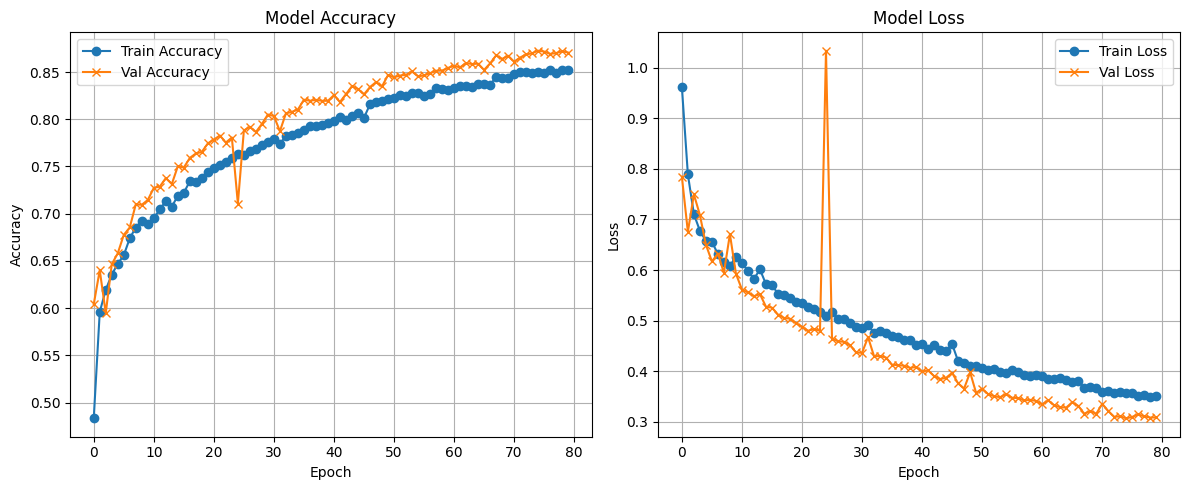

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# 📊 Plot the training curve
plot_training_history(history)


In [13]:
val_loss, val_accuracy = model.evaluate([X_rssi_val, X_sinr_val], y_val, verbose=0)
print(f"✅ Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"❌ Validation Loss: {val_loss:.4f}")


✅ Validation Accuracy: 87.26%
❌ Validation Loss: 0.3071


558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step
📋 Classification Report:
              precision    recall  f1-score   support

           0     0.8298    0.9220    0.8735      5960
           1     0.9216    0.8480    0.8832      6026
           2     0.8747    0.8477    0.8610      5865

    accuracy                         0.8726     17851
   macro avg     0.8754    0.8726    0.8726     17851
weighted avg     0.8755    0.8726    0.8727     17851



C:\Users\VEDANT DESHMUKH\AppData\Local\Temp\ipykernel_235360\1738817605.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


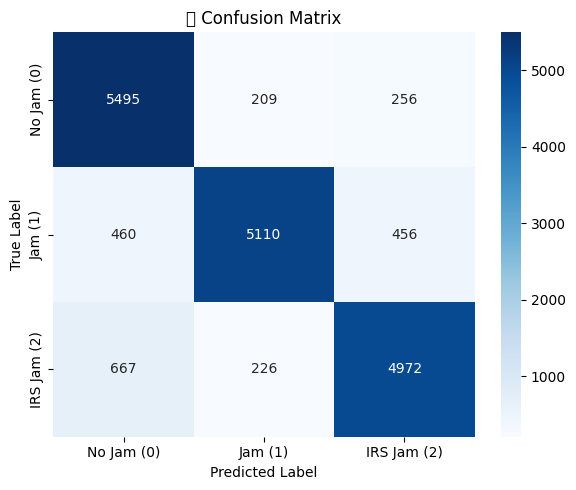

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 📈 Predictions
y_pred_probs = model.predict([X_rssi_val, X_sinr_val])
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_val.argmax(axis=1)

# 🧾 Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# 🧊 Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Jam (0)', 'Jam (1)', 'IRS Jam (2)'],
            yticklabels=['No Jam (0)', 'Jam (1)', 'IRS Jam (2)'])
plt.title('🔍 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [15]:
# Save model to file
model.save('irs_jam_detection_model_300_20.h5')
print("💾 Model saved to 'irs_jam_detection_model.h5'")


💾 Model saved to 'irs_jam_detection_model.h5'


558/558 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
📊 Classification Metrics (Per Class):
              precision    recall  f1-score       support
No Jam         0.829810  0.921980  0.873470   5960.000000
Jam            0.921551  0.847992  0.883243   6026.000000
IRS Jam        0.874736  0.847741  0.861027   5865.000000
accuracy       0.872612  0.872612  0.872612      0.872612
macro avg      0.875366  0.872571  0.872580  17851.000000
weighted avg   0.875540  0.872612  0.872681  17851.000000

✅ Overall Accuracy: 87.26%


C:\Users\VEDANT DESHMUKH\AppData\Local\Temp\ipykernel_235360\462229197.py:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\VEDANT DESHMUKH\OneDrive\Desktop\SEM 8\CV_Latest\3mins_IITG_lessAccuracy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


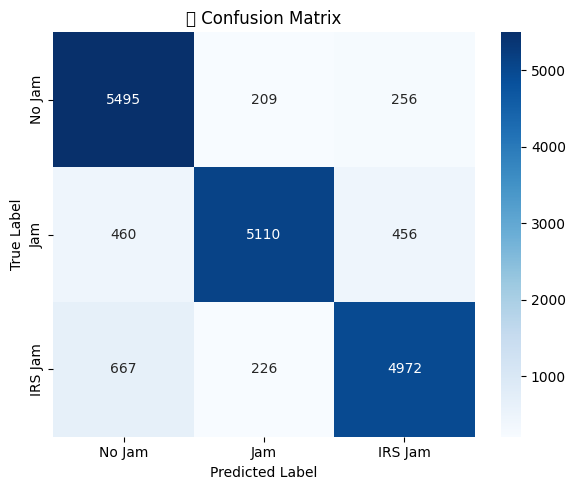

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔮 Predict on validation data
y_pred_probs = model.predict([X_rssi_val, X_sinr_val])
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_val.argmax(axis=1)

# 📋 Full Classification Report
report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=["No Jam", "Jam", "IRS Jam"])
report_df = pd.DataFrame(report_dict).transpose()

# 🎯 Print selected metrics neatly
print("📊 Classification Metrics (Per Class):")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

# ✅ Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Accuracy: {accuracy*100:.2f}%")

# 🧊 Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Jam", "Jam", "IRS Jam"],
            yticklabels=["No Jam", "Jam", "IRS Jam"])
plt.title('🔍 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [17]:
model.summary()

# STOP STOP STOP below cgboost, Random Forest

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ RSSI_Input          │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SINR_Input          │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 300, 1)    │          0 │ RSSI_Input[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 300, 1)    │          0 │ SINR_Input[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 150, 16)   │         96 │ gaussian_noise[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 150, 16)   │         96 │ gaussian_noise_1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 150, 16)   │         32 │ conv1d[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 16)   │         32 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 150, 32)   │      1,568 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 150, 32)   │      1,568 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 32)   │         64 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 32)   │         64 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 80,939 (316.17 KB)

 Trainable params: 26,979 (105.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,960 (210.79 KB)

In [12]:
from tensorflow.keras.models import load_model
model = load_model("irs_jam_detection_model_300_20.h5")


In [13]:
train_loss, train_accuracy = model.evaluate([X_rssi_train, X_sinr_train], y_train, verbose=1)
print(f"✅ Train Accuracy: {train_accuracy * 100:.2f}%")

1302/1302 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - accuracy: 0.8840 - loss: 0.2816
✅ Train Accuracy: 88.31%


In [14]:
val_loss, val_accuracy = model.evaluate([X_rssi_val, X_sinr_val], y_val, verbose=1)
print(f"✅ Validation Accuracy: {val_accuracy * 100:.2f}%")


558/558 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.8725 - loss: 0.3077
✅ Validation Accuracy: 87.23%
